<a href="https://colab.research.google.com/github/debarati-nath/10-2-class-classification-using-CIFAR10/blob/main/Question_3_%5BPython_numpy%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question:
[Python (Numpy)] Implement (in Numpy) a unidirectional multi-layer LSTM classifier with input and forget gates coupled. You can find information about this variant of LSTM here (look for CIFG). The model should accept a feature vector as input and emit the corresponding posterior. Then, train a character-based language model to generate text resembling Shakespeare (use any online dataset you see fit). How do you measure the quality of the generated text? Justify all the design decisions you’ve made in your training and inference pipelines.

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
from random import uniform

In [4]:
#Read the file from a specific location (here, from the drive). 
data = open("shakespear_text.txt", "r", encoding='utf-8').read() 
l_data = len(data)
print('Length of the data:', l_data)
print('------------\n')
print('Shakespeare data:\n\n', data[:500])

Length of the data: 1115393
------------

Shakespeare data:

 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [5]:
#Lower case letter. We need to do the lower case so that the program take 'The' and 'the' as same.
data_lowercase = data.lower()
print('Data in lower case:', data_lowercase[:200])
l_data_lowercase = len(data_lowercase) 

Data in lower case: first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you


In [ ]:
#Find out Unique character in the data
char = sorted(set(data_lowercase))
print(char)
l_char = len(char)

#Mapping the unique character into their indexes
char_to_index = {char1: ind for ind, char1 in enumerate(char)}

#Map character indexes to characers from the unique characters of the data
index_to_char = {char1: ind for char1, ind in enumerate(char)}

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Create LSTM class. I created class so that I can access the functions inside the class easily. We can also call the LSTM cell easily and more than once to optimize the losses.

In [ ]:
class LSTM:
    def __init__(self, char_to_index, index_to_char, l_char, hidden_layer = 100, seq_length = 25, epochs = 10, lr = 0.01, beta1=0.9, beta2=0.999):
        self.char_to_index = char_to_index
        self.index_to_char = index_to_char
        self.l_char = l_char
        self.hidden_layer = hidden_layer
        self.seq_length = seq_length
        self.epochs = epochs
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        
        #weight and bias. Used Xavier initialization is an well-known initializer
        self.params = {}
        Xav = 1/np.sqrt(self.l_char+self.hidden_layer)
        
        #Initialize the parameters
        #cell gate
        self.params['Wc'] = np.random.randn(self.hidden_layer, self.hidden_layer+self.l_char) * Xav
        self.params['bc'] = np.zeros((self.hidden_layer,1))
        #input gate
        self.params['Wi'] = np.random.randn(self.hidden_layer, self.hidden_layer+self.l_char) * Xav
        self.params['bi'] = np.zeros((self.hidden_layer,1))
        #forward gate
        self.params['Wf'] = np.random.randn(self.hidden_layer, self.hidden_layer+self.l_char) * Xav
        self.params['bf'] = np.ones((self.hidden_layer,1))
        #output gate
        self.params['Wo'] = np.random.randn(self.hidden_layer, self.hidden_layer+self.l_char) * Xav
        self.params['bo'] = np.zeros((self.hidden_layer,1))
        
        #output
        self.params["Wv"] = np.random.randn(self.l_char, self.hidden_layer) * (1 / np.sqrt(self.l_char))
        self.params["bv"] = np.zeros((self.l_char,1))
        
        #Initialize the gradients
        self.grads = {}
        self.adam_params = {}
        
        #Create key for providing spaces/locations for parameters
        for key in self.params:
            self.grads['d' + key] = np.zeros_like(self.params[key])
            self.adam_params['m' + key] = np.zeros_like(self.params[key])
            self.adam_params['v' + key] = np.zeros_like(self.params[key])
            
        self.smooth_loss = -np.log(1/self.l_char) * self.hidden_layer
        return

Create different function for further calling. It is easy way to create function for calling

In [ ]:
def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))


LSTM.sigmoid = sigmoid


def tanh(self, x):
    return np.tanh(x)

LSTM.tanh = tanh

def softmax(self, x):
    x_exp = np.exp(x - np.max(x)) 
    return x_exp / np.sum(x_exp)

LSTM.softmax = softmax

Create function for forward pass

In [ ]:
def forwardpass(self, x, h_prev, c_prev):
    z = np.row_stack((h_prev, x))

    f = self.sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])
    i = self.sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])
    c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])

    c = f * c_prev + i * c_bar
    o = self.sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])
    h = o * self.tanh(c)

    v = np.dot(self.params["Wv"], h) + self.params["bv"]
    y_hat = self.softmax(v)
    return y_hat, v, h, o, c, c_bar, i, f, z

LSTM.forwardpass = forwardpass

Create Function for backward pass


In [ ]:
def backwardpass(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
    dv = np.copy(y_hat)
    dv[y] -= 1 

    self.grads["dWv"] += np.dot(dv, h.T)
    self.grads["dbv"] += dv

    dh = np.dot(self.params["Wv"].T, dv)
    dh += dh_next
    
    do = dh * self.tanh(c)
    da_o = do * o*(1-o)
    self.grads["dWo"] += np.dot(da_o, z.T)
    self.grads["dbo"] += da_o

    dc = dh * o * (1-self.tanh(c)**2)
    dc += dc_next

    dc_bar = dc * i
    da_c = dc_bar * (1 - c_bar**2)
    self.grads["dWc"] += np.dot(da_c, z.T)
    self.grads["dbc"] += da_c

    di = dc * c_bar
    da_i = di * i*(1-i) 
    self.grads["dWi"] += np.dot(da_i, z.T)
    self.grads["dbi"] += da_i

    df = dc * c_prev
    da_f = df * f * (1 - f)
    self.grads["dWf"] += np.dot(da_f, z.T)
    self.grads["dbf"] += da_f

    dz = (np.dot(self.params["Wf"].T, da_f)
         + np.dot(self.params["Wi"].T, da_i)
         + np.dot(self.params["Wc"].T, da_c)
         + np.dot(self.params["Wo"].T, da_o))

    dh_prev = dz[:self.hidden_layer, :]
    dc_prev = f * dc
    return dh_prev, dc_prev

LSTM.backwardpass = backwardpass

In [ ]:
#Create function for reset gradients. Clear gradients before the backward pass
def reset_grads(self):
    for key in self.grads:
        self.grads[key].fill(0)
    return

LSTM.reset_grads = reset_grads

#create a function for forward backward pass
def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
    x, z = {}, {}
    f, i, c_bar, c, o, y_hat, v, h = {}, {}, {}, {}, {}, {}, {}, {}

    # Values at t= - 1
    h[-1] = h_prev
    c[-1] = c_prev

    loss = 0
    for t in range(self.seq_length): 
        x[t] = np.zeros((self.l_char, 1))
        x[t][x_batch[t]] = 1

        y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = self.forwardpass(x[t], h[t-1], c[t-1])

        loss += -np.log(y_hat[t][y_batch[t], 0])

    self.reset_grads()

    dh_next = np.zeros_like(h[0])
    dc_next = np.zeros_like(c[0])

    for t in reversed(range(self.seq_length)):
        dh_next, dc_next = self.backwardpass(y_batch[t], y_hat[t], dh_next, 
                                              dc_next, c[t-1], z[t], f[t], i[t], 
                                              c_bar[t], c[t], o[t], h[t]) 
    return loss, h[self.seq_length - 1], c[self.seq_length - 1]

LSTM.forward_backward = forward_backward

Sample the data for updating and displaying.
Create a function for data sample

In [ ]:
def sample(self, h_prev, c_prev, sample_size):
    x = np.zeros((self.l_char, 1))
    h = h_prev
    c = c_prev
    sample_string = "" 
    
    for t in range(sample_size):
        y_hat, _, h, _, c, _, _, _, _ = self.forwardpass(x, h, c)        
        
        # Evaluate a random index within the probability distribution of y_hat(ravel())
        index = np.random.choice(range(self.l_char), p=y_hat.ravel())
        x = np.zeros((self.l_char, 1))
        x[index] = 1
        
        #find the char with the sampled index and concat to the output string
        chars = self.index_to_char[index]
        sample_string += chars
    return sample_string

LSTM.sample = sample

Need to clip gradiant to overcome the gradient exploding
Create a function for gradient clipping

In [ ]:
def clip_grads(self):
    for key in self.grads:
        np.clip(self.grads[key], -1, 1, out=self.grads[key])
    return

LSTM.clip_grads = clip_grads

In [ ]:
#Create function for gradient updating
def update_params(self, batch_num):
    for key in self.params:
        self.adam_params["m"+key] = self.adam_params["m"+key] * self.beta1 + \
                                    (1 - self.beta1) * self.grads["d"+key]
        self.adam_params["v"+key] = self.adam_params["v"+key] * self.beta2 + \
                                    (1 - self.beta2) * self.grads["d"+key]**2

        m_correlated = self.adam_params["m" + key] / (1 - self.beta1**batch_num)
        v_correlated = self.adam_params["v" + key] / (1 - self.beta2**batch_num) 
        self.params[key] -= self.lr * m_correlated / (np.sqrt(v_correlated) + 1e-8) 
    return

LSTM.update_params = update_params

In [ ]:
#Create a function for gradient checking
def gradient_check(self, x_batch, y_batch, h_prev, c_prev, num_checks=10, delta=1e-6):
        print("Gradient check...\n")

        _, _, _ = self.forward_backward(x_batch, y_batch, h_prev, c_prev)
        grads_numerical = self.grads

        for key in self.params:
            print("<---------", key, "--------->")
            test = True

            dims = self.params[key].shape
            grad_numerical = 0
            grad_analytical = 0
            
            #Used 10 samples
            for _ in range(num_checks):  
                
                #Length
                idx = int(uniform(0, self.params[key].size))
                old_val = self.params[key].flat[idx]
                
                #x = x + delta
                self.params[key].flat[idx] = old_val + delta
                J_plus, _, _ = self.forward_backward(x_batch, y_batch, h_prev, c_prev)
                
                #x = x- delta
                self.params[key].flat[idx] = old_val - delta
                J_minus, _, _ = self.forward_backward(x_batch, y_batch, h_prev, c_prev)
                
                #reset
                self.params[key].flat[idx] = old_val

                grad_numerical += (J_plus - J_minus) / (2 * delta)             #Numerical calculation
                grad_analytical += grads_numerical["d" + key].flat[idx]        #Analytical calculation

            grad_numerical /= num_checks
            grad_analytical /= num_checks
            
            #Evaluation error
            rel_error = abs(grad_analytical - grad_numerical) / abs(grad_analytical + grad_numerical)

         
            #Fixed limit to stop evaluation for each parameter 
            if rel_error > 1e-2:
                if not (grad_analytical < 1e-6 and grad_numerical < 1e-6):
                        test = False
                        assert (test)
     
                 
            print('Numerical gradient: \t%e, Analytical gradient: \t%e =>  Error: \t%e' % (grad_numerical, grad_analytical, rel_error))
      
        return

    
LSTM.gradient_check = gradient_check

In [ ]:
def train(self, X, verbose=True):
    #Store losses
    J = []  
    #Length of batches
    num_batches = len(X) // self.seq_length
    
    # Trim input to have full sequences
    X_trimmed = X[: num_batches * self.seq_length]  
   
    

    for epoch in range(self.epochs):
        h_prev = np.zeros((self.hidden_layer, 1))
        c_prev = np.zeros((self.hidden_layer, 1))

        for j in range(0, len(X_trimmed) - self.seq_length, self.seq_length):
            # prepare batches for training
            x_batch = [self.char_to_index[ch] for ch in X_trimmed[j: j + self.seq_length]]
            y_batch = [self.char_to_index[ch] for ch in X_trimmed[j + 1: j + self.seq_length + 1]]

            loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)

            # Smooth out loss and store in list
            self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
            J.append(self.smooth_loss)

             # Check gradients
            if epoch == 0 and j == 0:
                self.gradient_check(x_batch, y_batch, h_prev, c_prev, 10, 1e-7)
            
            #Gradient clipping
            self.clip_grads()
            
            #Update gradient
            batch_num = epoch * self.epochs + j / self.seq_length + 1
            self.update_params(batch_num)

            # Print out loss and sample string
            if verbose:
                if j % 400000 == 0:
                    print('Epoch:', epoch, '\tBatch:', j, "-", j + self.seq_length,
                          '\tLoss:', round(self.smooth_loss, 2))
                    s = self.sample(h_prev, c_prev, sample_size=250)
                    print(s, "\n")
                    
            
    return J, self.params

LSTM.train = train

Call the LSTM class as model. Then, training the data

In [ ]:
model = LSTM(char_to_index, index_to_char, l_char, epochs = 10, lr = 0.01)

J, params = model.train(data_lowercase)

Gradient check...

<--------- Wc --------->
Numerical gradient: 	8.981466e-03, Analytical gradient: 	8.981473e-03 =>  Error: 	3.972796e-07
<--------- bc --------->
Numerical gradient: 	4.837937e-02, Analytical gradient: 	4.837929e-02 =>  Error: 	8.062746e-07
<--------- Wi --------->
Numerical gradient: 	1.375042e-04, Analytical gradient: 	1.375900e-04 =>  Error: 	3.118371e-04
<--------- bi --------->
Numerical gradient: 	5.030564e-03, Analytical gradient: 	5.030541e-03 =>  Error: 	2.344163e-06
<--------- Wf --------->
Numerical gradient: 	5.993641e-04, Analytical gradient: 	5.993248e-04 =>  Error: 	3.279500e-05
<--------- bf --------->
Numerical gradient: 	1.649120e-02, Analytical gradient: 	1.649116e-02 =>  Error: 	1.122479e-06
<--------- Wo --------->
Numerical gradient: 	-7.998580e-04, Analytical gradient: 	-7.998698e-04 =>  Error: 	7.407268e-06
<--------- bo --------->
Numerical gradient: 	4.297313e-03, Analytical gradient: 	4.297312e-03 =>  Error: 	1.341291e-07
<--------- Wv -----

Text(0.5, 1.0, 'Total training loss over iterations')

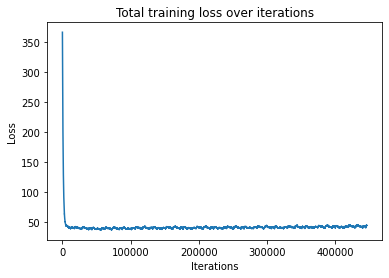

In [ ]:
plt.plot([i for i in range(len(J))], J)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Total training loss over iterations')